In [56]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

import pandas as pd
import numpy as np

import sqlite3
import pandas as pd
import json

In [57]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [58]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [59]:
con = sqlite3.connect('site/amc10_problems.db')

cursor = con.cursor()
cursor.execute('SELECT * FROM problem')

problems_data = pd.DataFrame(cursor.fetchall(), columns=['id','test','number','choices','problem','answer','labels','difficulty'])

In [60]:
problems_data['test'] = problems_data['test'].apply(json.loads)
problems_data['year'] = problems_data['test'].apply(lambda x: str(x[0]))
problems_data['instance'] = problems_data['test'].apply(lambda x: x[2])

problems_data.head(5)

,id,test,number,choices,problem,answer,labels,difficulty,year,instance
0,1,"[2015, 10, A]",1,"[""\\ -125"", ""\\ -120"", ""\\ \\frac{1}{5}"", ""\\ ...",<html><head></head><body><p>What is the value ...,"""C""",None,1,2015,A
1,2,"[2015, 10, A]",2,"[""\\ 3"", ""\\ 5"", ""\\ 7"", ""\\ 9"", ""\\ 11""]",<html><head></head><body><p>A box contains a c...,"""D""",None,1,2015,A
2,3,"[2015, 10, A]",3,"[""\\ 9"", ""\\ 18"", ""\\ 20"", ""\\ 22"", ""\\ 24""]",<html><head></head><body><p>Ann made a <img al...,"""D""",None,1,2015,A
3,4,"[2015, 10, A]",4,"[""\\ \\frac{1}{12}"", ""\\ \\frac{1}{6}"", ""\\ \\...","<html><head></head><body><p>Pablo, Sofia, and ...","""B""",None,1,2015,A
4,5,"[2015, 10, A]",5,"[""\\ 81"", ""\\ 85"", ""\\ 91"", ""\\ 94"", ""\\ 95""]",<html><head></head><body><p>Mr. Patrick teache...,"""E""",None,1,2015,A


In [61]:
problems_data['year'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2021_Fall', '2022'], dtype=object)

In [62]:
problems_data = problems_data[problems_data['year'].isin(['2020', '2021_Fall', '2021', '2022'])]
problems_data.set_index('id')

,test,number,choices,problem,answer,labels,difficulty,year,instance
id,,,,,,,,,
244,"[2020, 10, A]",1,"[""\\ {-}\\frac{2}{3}"", ""\\ \\frac{7}{36}"", ""\\...",<html><head></head><body><p>What value of <img...,"""E""",None,1,2020,A
245,"[2020, 10, A]",2,"["" 0 "", "" 15 "", "" 30 "", "" 45 "", "" 60""]",<html><head></head><body><p>The numbers <img a...,"""C""",None,1,2020,A
246,"[2020, 10, A]",3,"["" {-}1 "", "" 1 "", "" \\frac{abc}{60} "", "" \\...",<html><head></head><body><p>Assuming <img alt=...,"""A""",None,1,2020,A
247,"[2020, 10, A]",4,"[""\\ 20"", ""\\ 22"", ""\\ 24"", ""\\ 25"", ""\\ 26""]",<html><head></head><body><p>A driver travels f...,"""E""",None,1,2020,A
248,"[2020, 10, A]",5,"["" 12 "", "" 15 "", "" 18 "", "" 21 "", "" 25""]",<html><head></head><body><p>What is the sum of...,"""C""",None,1,2020,A
...,...,...,...,...,...,...,...,...,...
438,"[2022, 10, B]",21,"[""\\ 10 "", ""\\ 13 "", ""\\ 19 "", ""\\ 20 "", ""\\ 23""]","<html><head></head><body><p>Let <img alt=""$P(x...","""E""",None,5,2022,B
439,"[2022, 10, B]",22,"[""~48\\pi"", ""~68\\pi"", ""~96\\pi"", ""~102\\pi"", ...","<html><head></head><body><p>Let <img alt=""$S$""...","""E""",None,5,2022,B
440,"[2022, 10, B]",23,"[""\\frac{1}{3} "", ""\\frac{1}{2} "", ""\\frac{2...",<html><head></head><body><p>Ant Amelia starts ...,"""C""",None,5,2022,B


In [63]:
labeled_data = pd.read_csv('problem_labels.csv').replace([True,False],[1,0])
labeled_data.shape

(200, 83)

In [64]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,Dice Problems,Card Problems,Placing/Picking/Labeling Problems,Stars and Bars,Expected Value,Recursive Counting,Conditional Probability,Complementary Counting,States,Principle of Inclusion-Exclusion
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020,10,B,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,2020,10,B,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,2020,10,B,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,2020,10,B,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
miscellaneous = (6,22)
algebra = (22,43)
geometry = (43,61)
number_theory = (61,69)
combinatorics = (69,)

In [66]:
labeled_data['Miscellaneous'] = labeled_data[labeled_data.columns[6:22]].values.tolist()
labeled_data['Combinatorics'] = labeled_data[labeled_data.columns[69:83]].values.tolist()
labeled_data['Miscellaneous'] = labeled_data['Miscellaneous'].apply(lambda x: int(any(x)))
labeled_data['Combinatorics'] = labeled_data['Combinatorics'].apply(lambda x: int(any(x)))

In [67]:
labeled_data['labels'] = labeled_data[['Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics']].values.tolist()
labeled_data = labeled_data[['Year','Instance','Problem','labels']]
labeled_data

,Year,Instance,Problem,labels
0,2022,A,1,"[1, 1, 0, 0, 0]"
1,2022,A,2,"[0, 0, 0, 0, 0]"
2,2022,A,3,"[0, 0, 0, 0, 0]"
3,2022,A,4,"[1, 1, 0, 0, 0]"
4,2022,A,5,"[0, 0, 1, 0, 0]"
...,...,...,...,...
195,2020,B,21,"[0, 0, 1, 0, 0]"
196,2020,B,22,"[0, 1, 0, 0, 0]"
197,2020,B,23,"[0, 0, 1, 0, 0]"
198,2020,B,24,"[1, 1, 0, 0, 0]"


In [68]:
problems_data = problems_data[['year','instance','number','choices','problem']]
problems_data['problem'] = problems_data['problem'].map(lambda x: strip_tags(x))
problems_data['context'] = problems_data['problem'] + problems_data['choices']
problems_data.drop(columns=['problem','choices'],inplace=True)
labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_68995/3060729685.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)


In [69]:
problems_data = problems_data.merge(right=labeled_data,on=['year','instance','number'])

In [70]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-05

In [71]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',truncation_side='left',truncation=True)

In [72]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['context']
        self.targets = dataframe['labels']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [73]:
train_size = 0.8
training_data = problems_data.sample(frac=train_size, random_state=200).reset_index(drop=True)
validation_data = problems_data.drop(training_data.index).reset_index(drop=True)

In [74]:
training_dataset = MultiLabelDataset(training_data, tokenizer, MAX_LEN)
val_dataset = MultiLabelDataset(validation_data, tokenizer, MAX_LEN)

In [75]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_dataset, **train_params)
testing_loader = DataLoader(val_dataset, **test_params)

In [76]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        return self.classifier(pooler)

In [77]:
model = DistilBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [78]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [79]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [80]:
def train_model(epoch):
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        
        outputs = model(ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%1000==0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [81]:
for epoch in range(EPOCHS):
    train_model(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.678541898727417
Epoch: 1, Loss: 0.5377955436706543
Epoch: 2, Loss: 0.47005537152290344
Epoch: 3, Loss: 0.4840335547924042
Epoch: 4, Loss: 0.46523138880729675
Epoch: 5, Loss: 0.4216192960739136
Epoch: 6, Loss: 0.3991524577140808
Epoch: 7, Loss: 0.2760455310344696
Epoch: 8, Loss: 0.29814356565475464
Epoch: 9, Loss: 0.27728700637817383
Epoch: 10, Loss: 0.3202762305736542
Epoch: 11, Loss: 0.242680162191391
Epoch: 12, Loss: 0.18341049551963806
Epoch: 13, Loss: 0.3181200325489044
Epoch: 14, Loss: 0.19474822282791138
Epoch: 15, Loss: 0.23076112568378448
Epoch: 16, Loss: 0.11714722216129303
Epoch: 17, Loss: 0.10323575884103775
Epoch: 18, Loss: 0.16153723001480103
Epoch: 19, Loss: 0.11517342180013657


In [82]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 0.85
F1 Score (Micro) = 0.8979591836734695
F1 Score (Macro) = 0.876470588235294


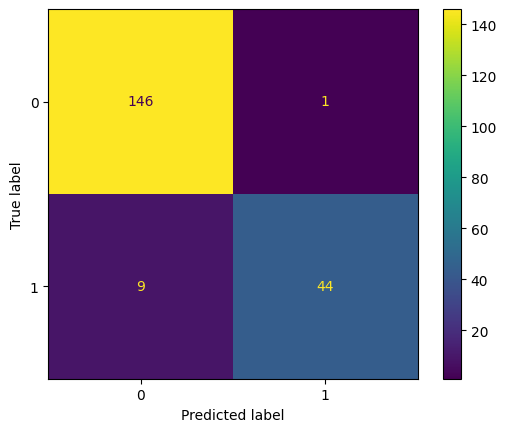

In [85]:
from itertools import chain

outputs, targets = validation(testing_loader)

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


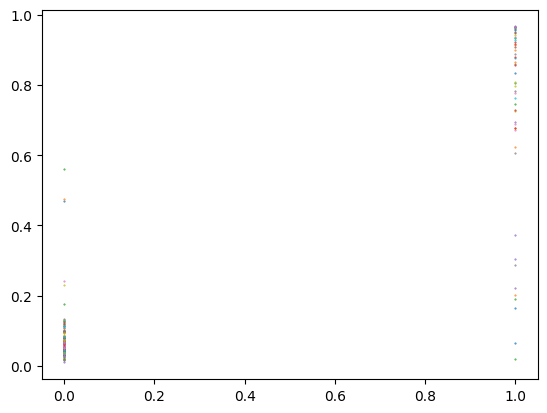

In [84]:
outputs, targets = validation(testing_loader)
import matplotlib.pyplot as plt

for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.show()